<a href="https://colab.research.google.com/github/pengdoong/scorePrediction/blob/main/scorePrediction_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px


In [ ]:
from google.colab import files
data_to_load = files.upload()
import io
df = pd.read_csv(io.BytesIO(data_to_load['db_two.csv']))
df.head()

Saving db_two.csv to db_two (1).csv


,school,GPA,Score
0,0.590972,0.807407,108.77
1,0.482687,0.866667,108.00
2,1.000000,0.903704,108.00
3,0.465405,0.892593,107.17
4,0.542435,0.803704,106.99


In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

# Train - Test
X_trainval, X_test, y_trainval, y_test  = train_test_split(X, y, test_size= 7596, shuffle = False)


# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)





In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [ ]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
NUM_FEATURES = len(X.columns)

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
            x = self.relu(self.layer_1(inputs))
            x = self.relu(self.layer_2(x))
            x = self.relu(self.layer_3(x))
            x = self.layer_out(x)
            return (x)
    def predict(self, test_inputs):
            x = self.relu(self.layer_1(test_inputs))
            x = self.relu(self.layer_2(x))
            x = self.relu(self.layer_3(x))
            x = self.layer_out(x)
            return (x)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


MultipleRegression(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
loss_stats = {
    'train': [],
    "val": []
}

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 136.44751 | Val Loss: 136.69697
Epoch 002: | Train Loss: 135.08495 | Val Loss: 135.40318
Epoch 003: | Train Loss: 133.78259 | Val Loss: 134.19167
Epoch 004: | Train Loss: 132.52549 | Val Loss: 133.03226
Epoch 005: | Train Loss: 131.41622 | Val Loss: 131.96063
Epoch 006: | Train Loss: 130.36632 | Val Loss: 130.99770
Epoch 007: | Train Loss: 129.25747 | Val Loss: 129.95336
Epoch 008: | Train Loss: 128.26315 | Val Loss: 129.05119
Epoch 009: | Train Loss: 127.29479 | Val Loss: 128.14200
Epoch 010: | Train Loss: 126.42337 | Val Loss: 127.34831
Epoch 011: | Train Loss: 125.56005 | Val Loss: 126.52219
Epoch 012: | Train Loss: 124.78814 | Val Loss: 125.87897
Epoch 013: | Train Loss: 124.18381 | Val Loss: 125.20988
Epoch 014: | Train Loss: 123.35506 | Val Loss: 124.52411
Epoch 015: | Train Loss: 122.71455 | Val Loss: 124.06394
Epoch 016: | Train Loss: 122.21334 | Val Loss: 123.43853
Epoch 017: | Train Loss: 121.62318 | Val Loss: 122.92963
Epoch 018: | Train Loss: 121.09

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

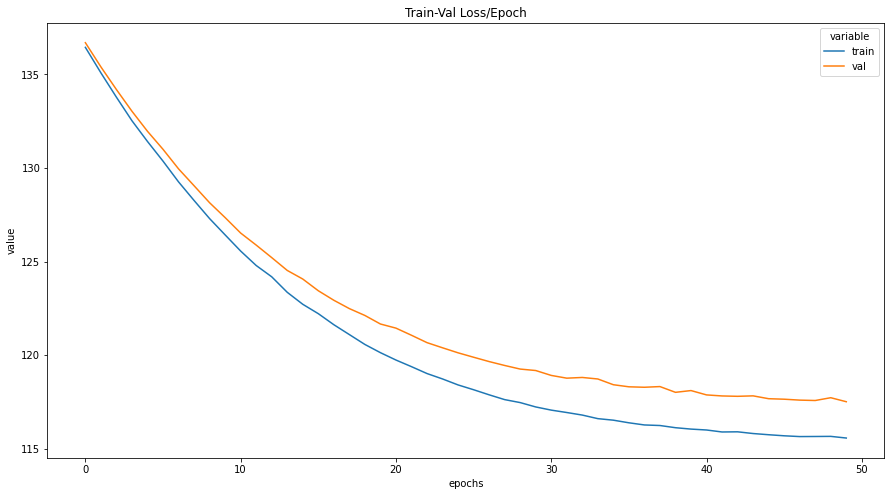

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
            
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
      
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 124.225365123775
R^2 : 0.3536909265392607
